In [2]:
# Savage-Dickey density ratio test for nested models
# Verdinelli, I., & Wasserman, L. (1995). Computing Bayes factors using a generalization of the Savage-Dickey density ratio. Journal of the American Statistical Association, 90(430), 614-618.

### Interpretation of the Bayes factor in terms of simple (nested) or complex model
def interpret_bayes_factor(bf):
    if bf < 1:
        interpretation = "Evidence favors the simpler model"
    elif 1 <= bf < 3:
        interpretation = "Anecdotal evidence for the complex model"
    elif 3 <= bf < 10:
        interpretation = "Substantial evidence for the complex model"
    elif 10 <= bf < 30:
        interpretation = "Strong evidence for the complex model"
    elif 30 <= bf < 100:
        interpretation = "Very strong evidence for the complex model"
    else:
        interpretation = "Decisive evidence for the complex model"
    print(f"Bayes Factor: {bf:.3g} - {interpretation}")
    


In [14]:
### Imports
import re
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t as t_test
from scipy.stats import norm
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
### Color list of dark organges in named colors by number
dark_oranges = sns.color_palette("Oranges", n_colors=9)[4:]
dark_purples = sns.color_palette("Purples", n_colors=9)[4:]
dark_greens = sns.color_palette("Greens", n_colors=9)[4:]

In [5]:
### Open data
path = "/home/jmindlin/BF_codes/data/DCENT_GMST_statistics.txt"

# 1) Find the header line ("Year,GMST (°C),...")
with open(path, "r", encoding="utf-8") as f:
    lines = f.readlines()

start = next(i for i, line in enumerate(lines) if line.strip().startswith("Year,"))


# 2) Read CSV from that header line onward; allow commas with spaces
df = pd.read_csv(
    path,
    skiprows=start,               # start at the header line
    engine="python",
    sep=r"\s*,\s*",               # split on commas, ignoring surrounding spaces
    comment=None
)

# 3) Clean column names to something easy to use
rename_map = {
    "Year": "year",
    "GMST (°C)": "gmst",
    "1 s.d. (°C)": "gmst_sd",
    "GMST non infilled (°C)": "gmst_noninf",
    "1 s.d. (°C; non  infilled)": "gmst_noninf_sd",
}
# in case of double spaces etc., normalize header keys first
df.columns = [re.sub(r"\s+", " ", c).strip() for c in df.columns]
rename_map_norm = {re.sub(r"\s+", " ", k).strip(): v for k, v in rename_map.items()}
df = df.rename(columns=rename_map_norm)

# 4) Ensure numeric dtypes
for c in ["year", "gmst", "gmst_sd", "gmst_noninf", "gmst_noninf_sd"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 5) Convert to xarray (optional)
ds = xr.Dataset(
    {
        "GMST": (["year"], df["gmst"].values),
        "GMST_sd": (["year"], df["gmst_sd"].values),
        "GMST_non_infilled": (["year"], df["gmst_noninf"].values),
        "GMST_non_infilled_sd": (["year"], df["gmst_noninf_sd"].values),
    },
    coords={"year": df["year"].values.astype(int)},
)
ds_full = ds.copy()
ds = ds - ds.sel(year=slice('1951','1980')).mean(dim='year')

In [6]:
# --- Shape data ---
t = ds.sel(year=slice('1950','2024')).year
y = ds['GMST'].sel(year=slice('1950','2024')).values
n = len(y)


### Linear, Quadratic and Quadratic+ENSO models

oni_path = '/home/jmindlin/BF_codes/data/oni_data.txt'

def load_oni_xarray(src):
    df = np.loadtxt(src,skiprows=1, max_rows=76)
    oni = np.concatenate([df[i,1:13].flatten() for i in range(df.shape[0]-1)])
    t = pd.date_range('1950-01-01', '2025-01-01', freq='ME')
    da = xr.DataArray(oni,dims=["time"],coords={"time": t}, name="oni",attrs={    "units": "degC",    "source": 'NOAA'})
    return da

oni = load_oni_xarray(oni_path)

# Select common period
oni_annual = oni.groupby('time.year').mean(dim='time')

### Linear model
X_lin = np.column_stack([np.ones(n), t])
beta_lin, *_ = np.linalg.lstsq(X_lin, y, rcond=None)
yhat_lin = X_lin @ beta_lin
resid_lin = y - yhat_lin

### Quadratic model
X_quad = np.column_stack([np.ones(n), t, t**2])
beta_quad, *_ = np.linalg.lstsq(X_quad, y, rcond=None)
yhat_quad = X_quad @ beta_quad
resid_quad = y - yhat_quad

### Quadratic + ENSO model
X_quad_enso = np.column_stack([np.ones(n), t, t**2, oni_annual.values])
beta_quad_enso, *_ = np.linalg.lstsq(X_quad_enso, y, rcond=None)
yhat_quad_enso = X_quad_enso @ beta_quad_enso
resid_quad_enso = y - yhat_quad_enso



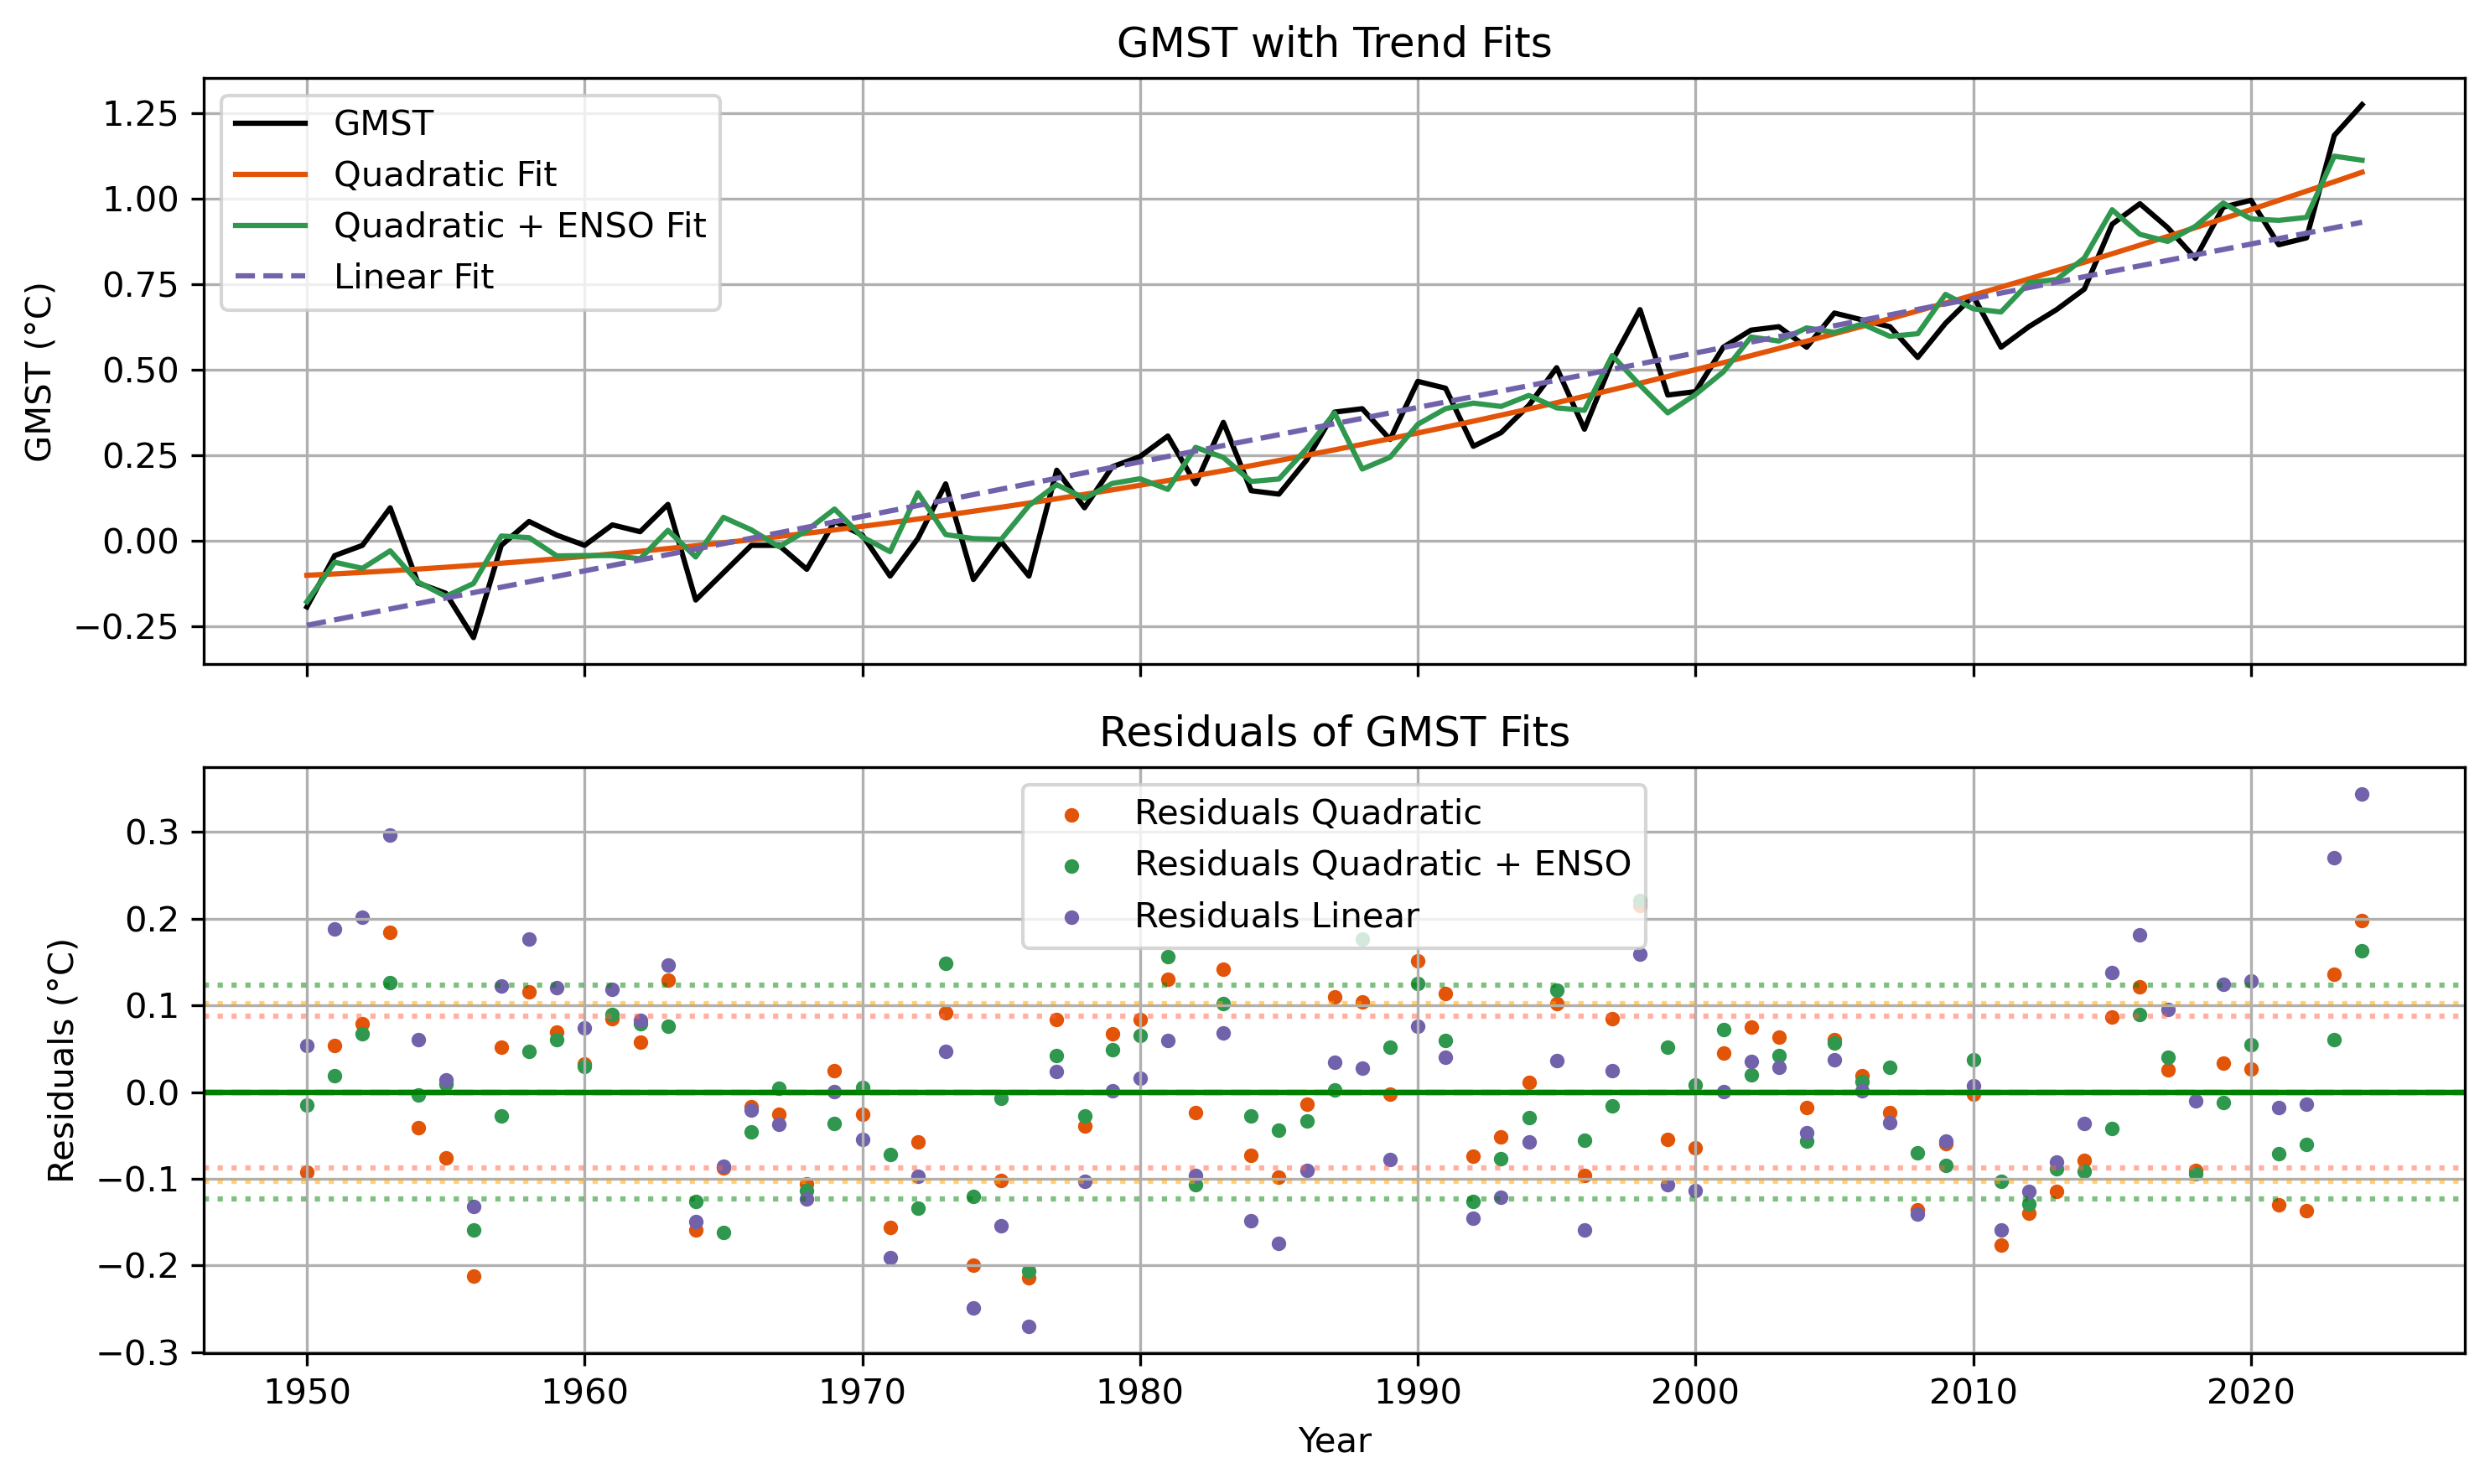

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True,dpi=300)

# === Panel 1: GMST Fits ===
axs[0].plot(t, y, label='GMST', color='black')
axs[0].plot(t, yhat_quad, label='Quadratic Fit', color=dark_oranges[2])
axs[0].plot(t, yhat_quad_enso, label='Quadratic + ENSO Fit', color=dark_greens[2])
axs[0].plot(t, yhat_lin, label='Linear Fit', linestyle='--',color=dar_purples[2])

axs[0].set_ylabel('GMST (°C)')
axs[0].set_title('GMST with Trend Fits')
axs[0].legend()
axs[0].grid()

# === Panel 2: Residuals ===
axs[1].scatter(t, resid_quad, label='Residuals Quadratic', s=10, color=dark_oranges[2])
axs[1].scatter(t, resid_quad_enso, label='Residuals Quadratic + ENSO', s=10, color=dark_greens[2])
axs[1].scatter(t, resid_lin, label='Residuals Linear', s=10, color=dar_purples[2])

axs[1].axhline(0, color='k', linestyle='--')

# Residual stats: mean ± std for each model
for resid, color in zip(
    [resid_quad, resid_quad_enso, resid_lin],
    ['Orange', 'Tomato', 'green']
):
    mean = np.mean(resid)
    std = np.std(resid)
    axs[1].axhline(mean, color=color, linestyle='-')
    axs[1].axhline(mean + std, color=color, linestyle=':', alpha=0.5)
    axs[1].axhline(mean - std, color=color, linestyle=':', alpha=0.5)

axs[1].set_xlabel('Year')
axs[1].set_ylabel('Residuals (°C)')
axs[1].set_title('Residuals of GMST Fits')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


Bayes Factor (Linear vs Quadratic) via Savage-Dickey: 244.9091072694113
Quadratic coefficient (beta): 0.00016264247843200685
Quadratic coefficient standard error (se): 2.8790703339770425e-05
t-statistic for Quadratic coefficient: 5.649131822609505
p-value for Quadratic coefficient: 3.0174438570007567e-07


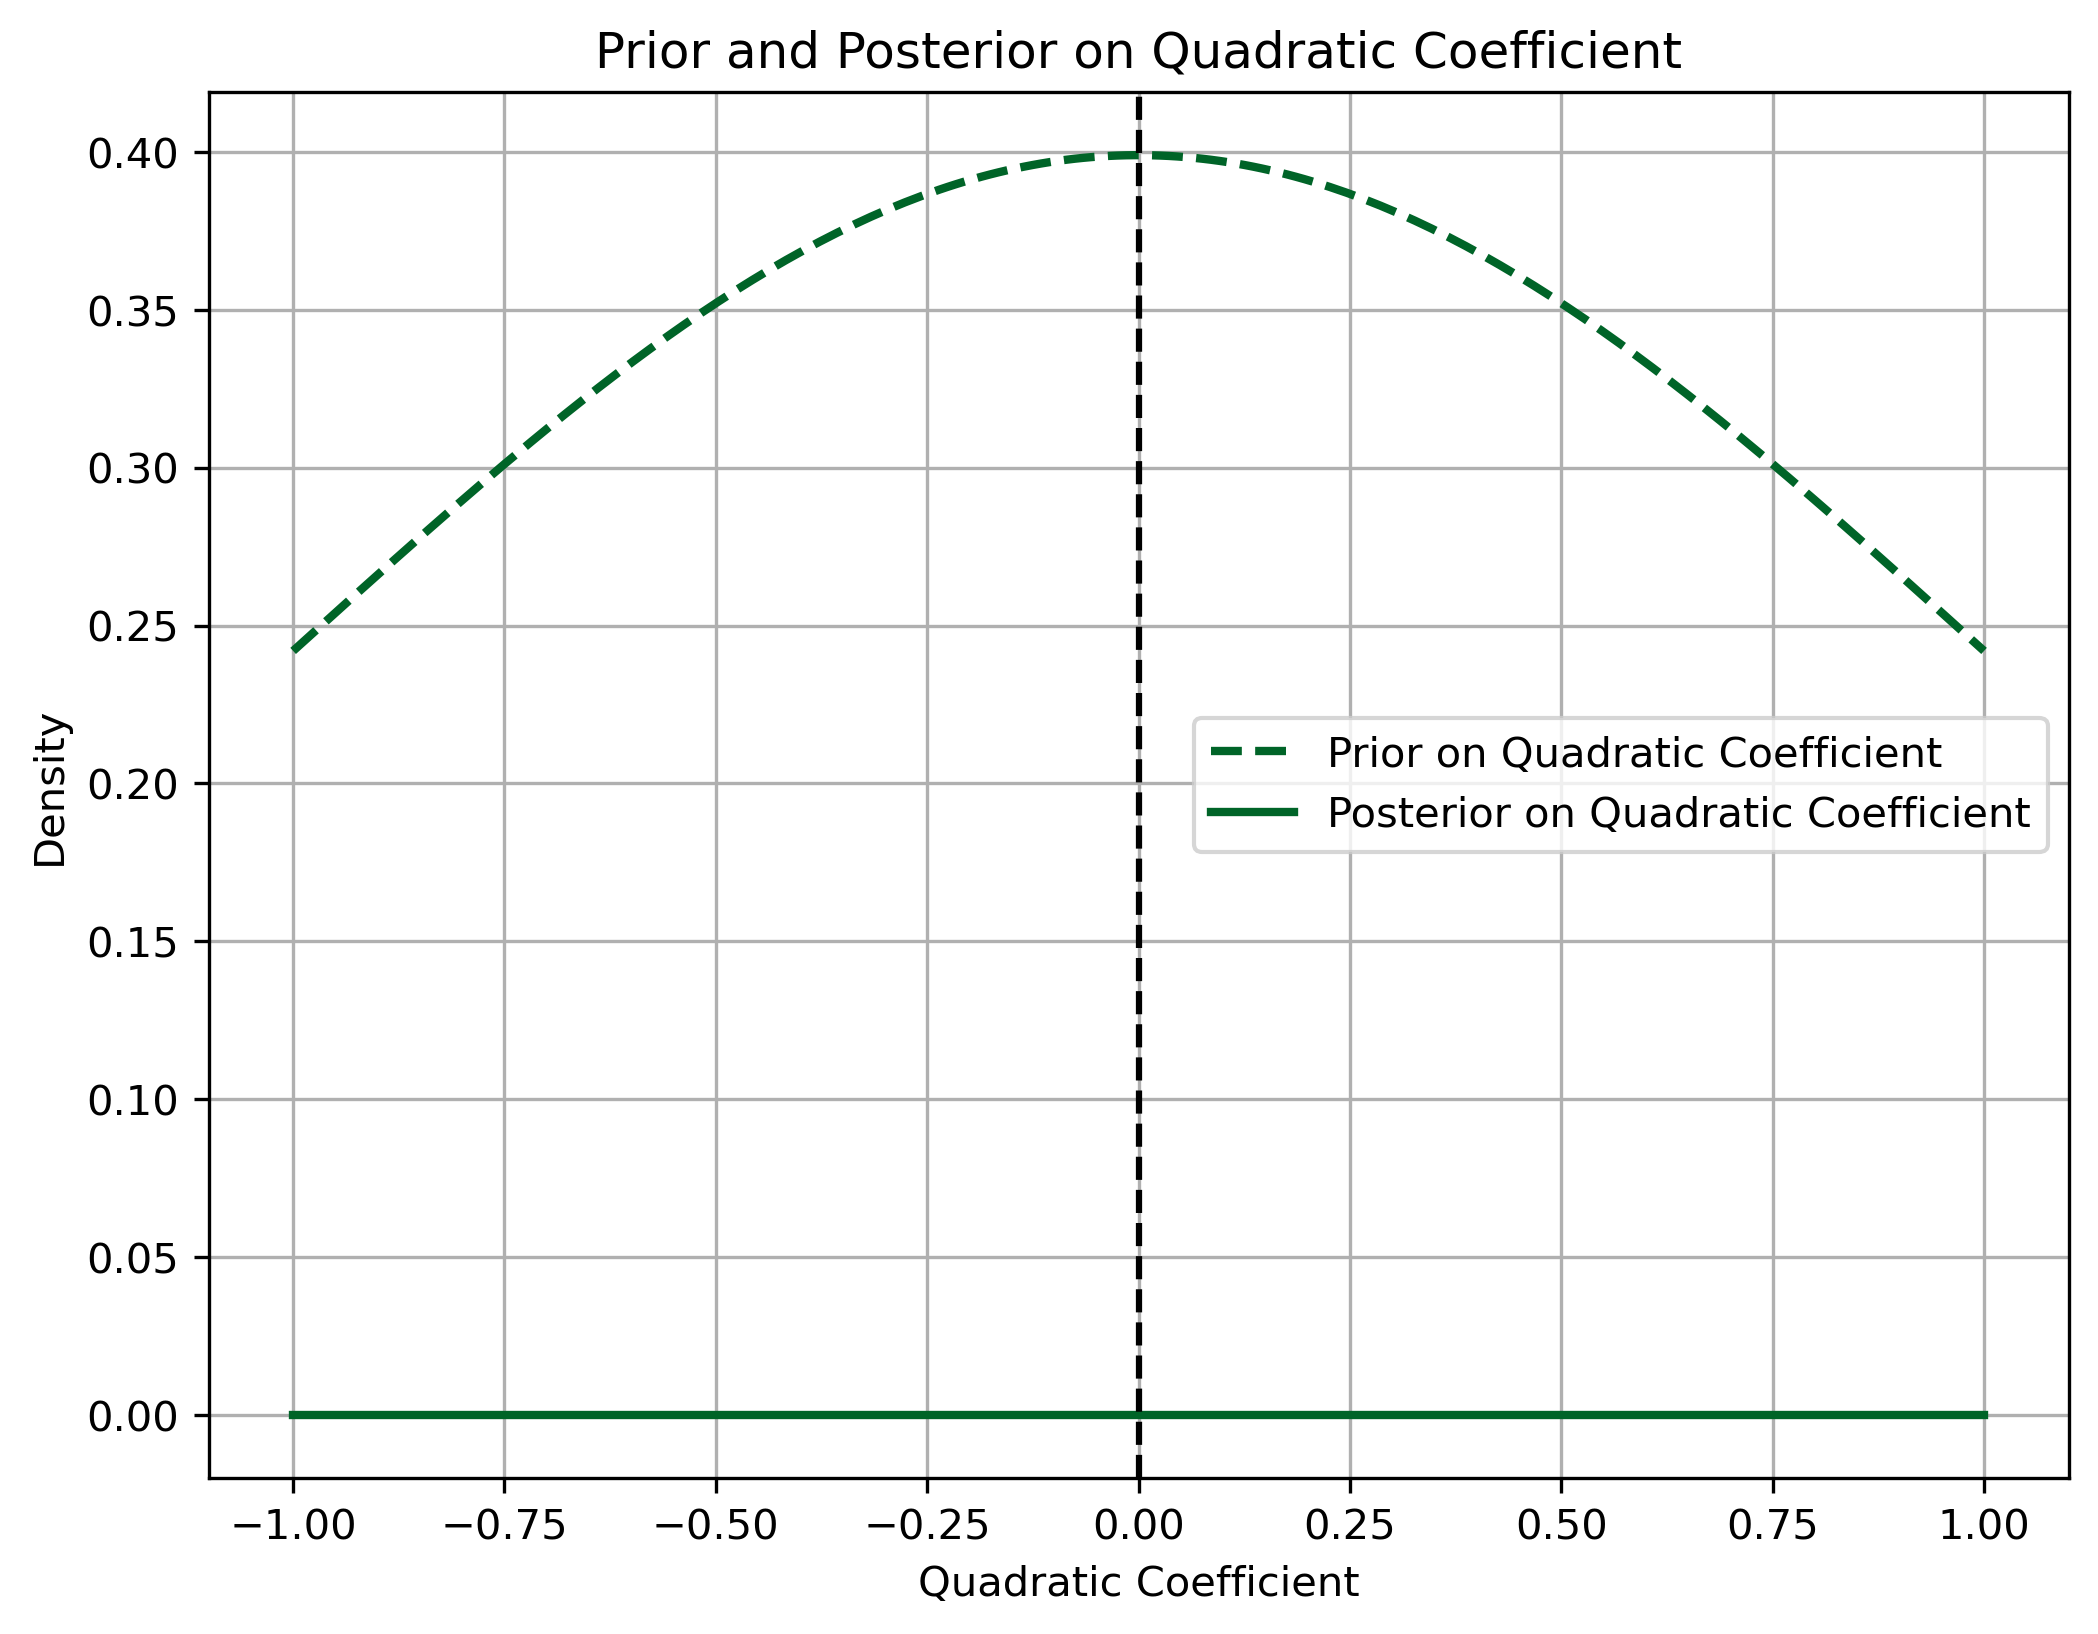

Bayes Factor: 245 - Decisive evidence for the complex model


In [8]:
### Test the two nested hypotheses, Linear vs Quadratic, via Bayes factor (Savage Dickey density ratio) test
# Prior on Quadratic coefficient: Normal(0, 1)

prior_quad = norm(loc=0, scale=1)
# Posterior on Quadratic coefficient: Normal(beta, se)
se_quad = np.sqrt(np.sum(resid_quad**2) / (n - X_quad.shape[1])) * np.sqrt(np.linalg.inv(X_quad.T @ X_quad)[-1, -1])
posterior_quad = norm(loc=beta_quad[-1], scale=se_quad)
# Bayes factor: prior density at 0 / posterior density at 0
bf_savage_dickey_quad = prior_quad.pdf(0) / posterior_quad.pdf(0)
print("Bayes Factor (Linear vs Quadratic) via Savage-Dickey:", bf_savage_dickey_quad)
print("Quadratic coefficient (beta):", beta_quad[-1])
print("Quadratic coefficient standard error (se):", se_quad)
### Frequentist test: t-test on Quadratic coefficient

t_stat_quad = beta_quad[-1] / se_quad
p_value_quad = 2 * (1 - t_test.cdf(np.abs(t_stat_quad), df=n - X_quad.shape[1]))
print("t-statistic for Quadratic coefficient:", t_stat_quad)
print("p-value for Quadratic coefficient:", p_value_quad)
plt.figure(figsize=(8,6), dpi=300)
x = np.linspace(-1, 1, 200)
plt.plot(x, prior_quad.pdf(x), label='Prior on Quadratic Coefficient', linestyle='--',linewidth=2,color=dark_greens[4])
plt.plot(x, posterior_quad.pdf(x), label='Posterior on Quadratic Coefficient', linewidth=2,color=dark_greens[4])
plt.axvline(0, color='k', linestyle='--')
plt.xlabel('Quadratic Coefficient')
plt.ylabel('Density')
plt.title('Prior and Posterior on Quadratic Coefficient')
plt.legend()
plt.grid()
plt.show()

interpret_bayes_factor(bf_savage_dickey_quad)  

In [9]:
### Quadratic coefficient
print("Quadratic coefficient (beta):", beta_quad[-1])

Quadratic coefficient (beta): 0.00016264247843200685


Bayes Factor (Quadratic vs Quadratic + ENSO) via Savage-Dickey: 9683.837904256923
ENSO coefficient (beta): 0.08647627485768242
ENSO coefficient standard error (se): 0.01678898029039961
t-statistic for ENSO coefficient: 5.150775887629809
p-value for ENSO coefficient: 2.2282370177872934e-06


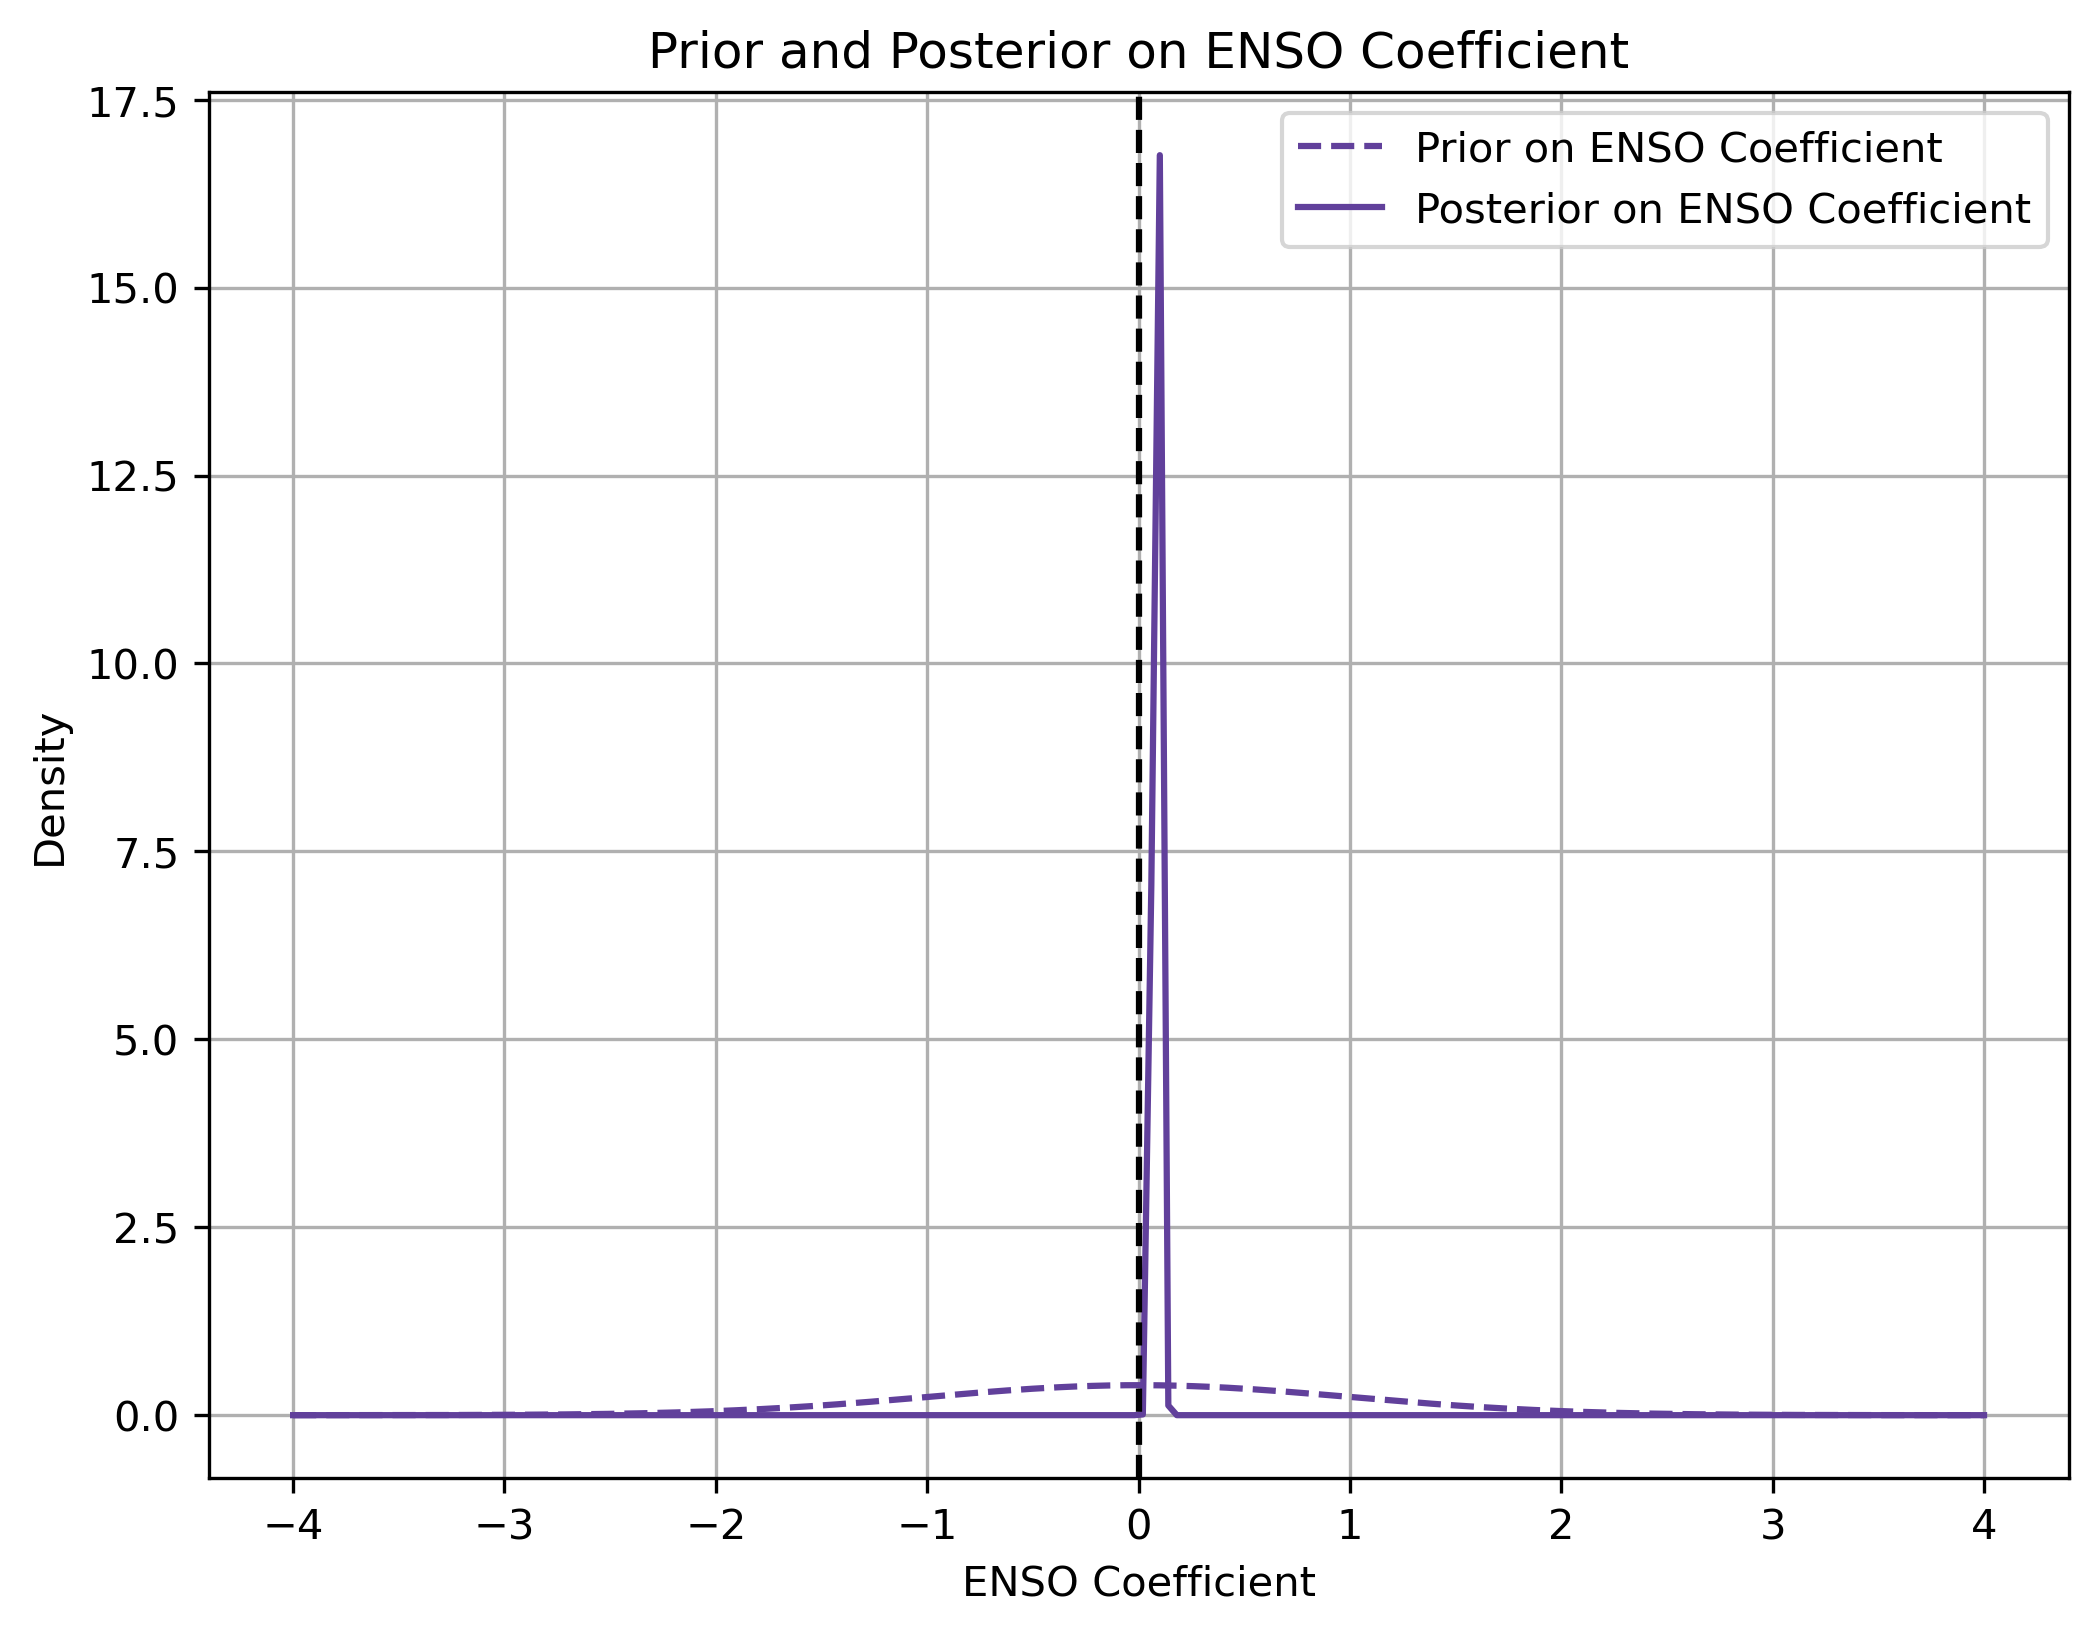

Bayes Factor: 9.68e+03 - Decisive evidence for the complex model


In [10]:
### Test the two nested hypotheses, Quadratic vs Quadratic + ENSO, via Bayes factor (Savage Dickey density ratio) test
# Prior on ENSO coefficient: Normal(0, 1)
from scipy.stats import norm
prior_enso = norm(loc=0, scale=1)
# Posterior on ENSO coefficient: Normal(beta, se)
se_enso = np.sqrt(np.sum(resid_quad_enso**2) / (n - X_quad_enso.shape[1])) * np.sqrt(np.linalg.inv(X_quad_enso.T @ X_quad_enso)[-1, -1])
posterior_enso = norm(loc=beta_quad_enso[-1], scale=se_enso)
# Bayes factor: prior density at 0 / posterior density at 0
bf_savage_dickey = prior_enso.pdf(0) / posterior_enso.pdf(0)
print("Bayes Factor (Quadratic vs Quadratic + ENSO) via Savage-Dickey:", bf_savage_dickey)
print("ENSO coefficient (beta):", beta_quad_enso[-1])
print("ENSO coefficient standard error (se):", se_enso)
### Frequentist test: t-test on ENSO coefficient
t_stat = beta_quad_enso[-1] / se_enso
p_value = 2 * (1 - t_test.cdf(np.abs(t_stat), df=n - X_quad_enso.shape[1]))
print("t-statistic for ENSO coefficient:", t_stat)
print("p-value for ENSO coefficient:", p_value)
plt.figure(figsize=(8,6), dpi=300)
x = np.linspace(-4, 4, 200)
plt.plot(x, prior_enso.pdf(x), label='Prior on ENSO Coefficient', linestyle='--', color=dark_purples[3])
plt.plot(x, posterior_enso.pdf(x), label='Posterior on ENSO Coefficient', color=dark_purples[3])
plt.axvline(0, color='k', linestyle='--')
plt.xlabel('ENSO Coefficient')
plt.ylabel('Density')
plt.title('Prior and Posterior on ENSO Coefficient')
plt.legend()
plt.grid()
plt.show()

interpret_bayes_factor(bf_savage_dickey)

/tmp/ipykernel_3059657/3231215564.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


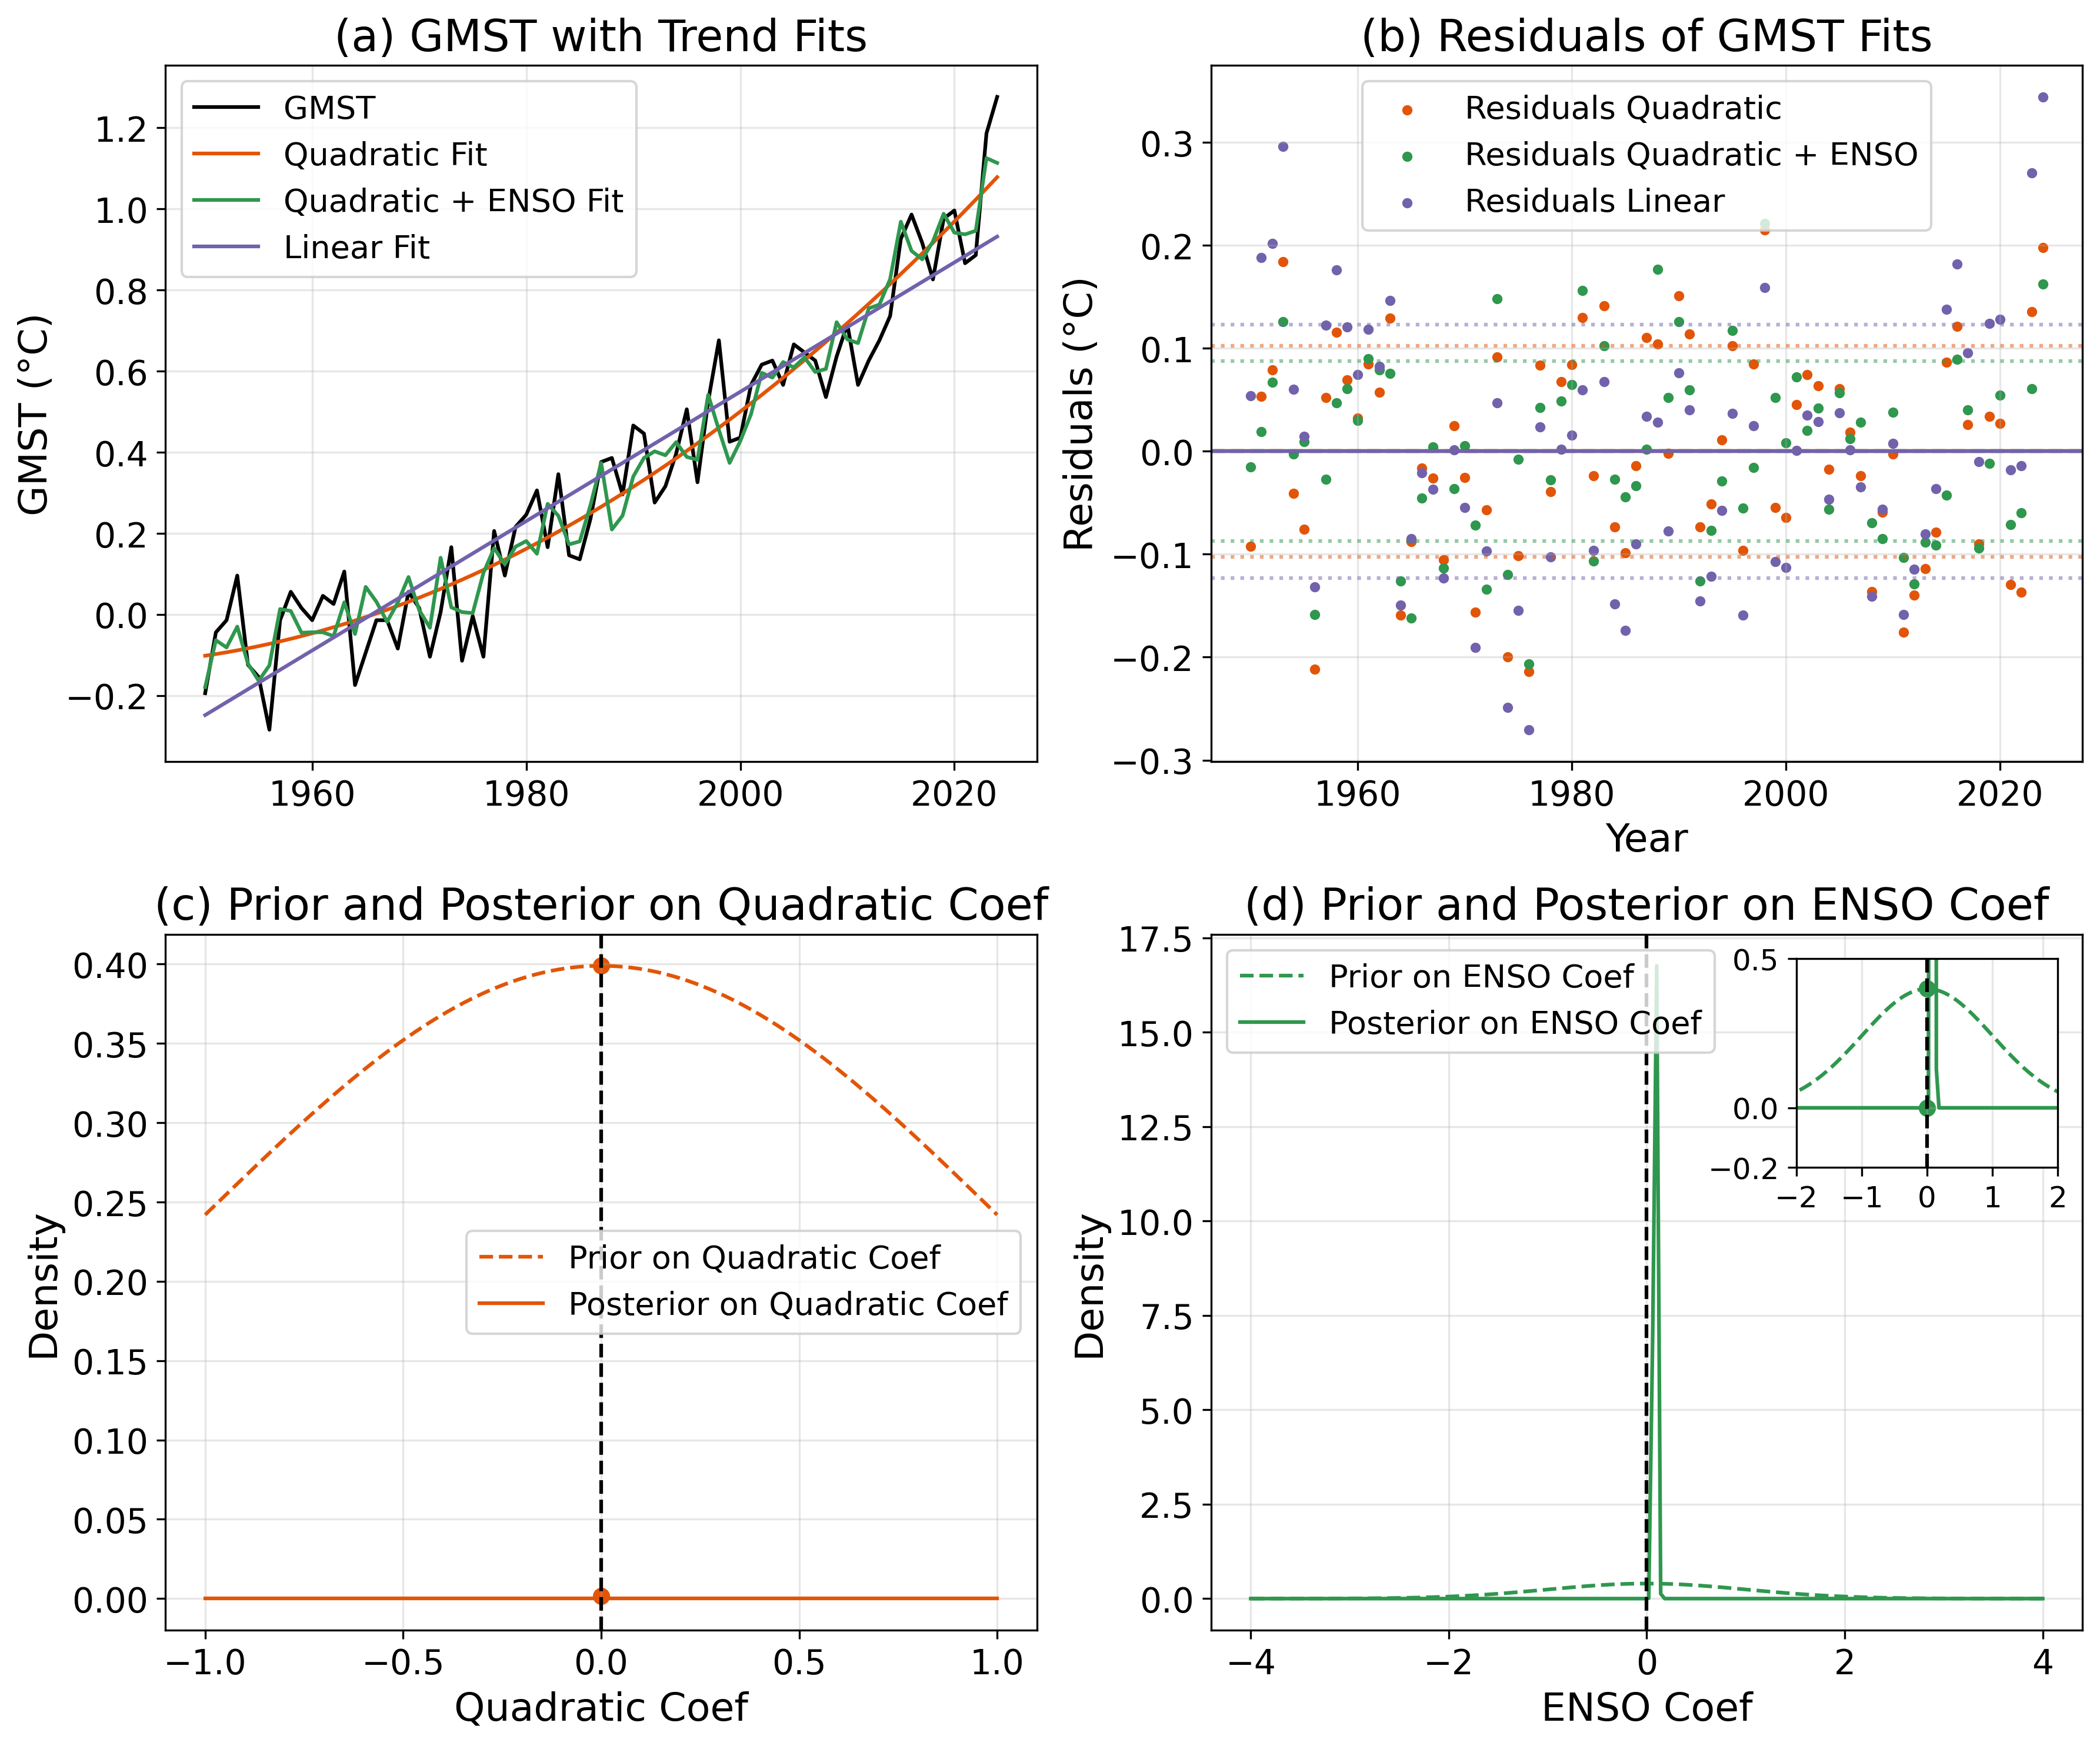

In [19]:
# === FONT SETTINGS ===
TITLE_FONTSIZE = 18
LABEL_FONTSIZE = 16
TICK_FONTSIZE = 14
LEGEND_FONTSIZE = 13

# === Figure ===
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=False, dpi=300)

# === Panel (a): GMST Fits ===
axs[0,0].plot(t, y, label='GMST', color='black')
axs[0,0].plot(t, yhat_quad, label='Quadratic Fit', color=dark_oranges[2])
axs[0,0].plot(t, yhat_quad_enso, label='Quadratic + ENSO Fit', color=dark_greens[2])
axs[0,0].plot(t, yhat_lin, label='Linear Fit', color=dark_purples[2])
axs[0,0].set_ylabel('GMST (°C)', fontsize=LABEL_FONTSIZE)
axs[0,0].set_title('(a) GMST with Trend Fits', fontsize=TITLE_FONTSIZE)
axs[0,0].tick_params(axis='both', labelsize=TICK_FONTSIZE)
axs[0,0].legend(fontsize=LEGEND_FONTSIZE)
axs[0,0].grid(alpha=0.3)

# === Panel (b): Residuals ===
axs[0,1].scatter(t, resid_quad, label='Residuals Quadratic', s=10, color=dark_oranges[2])
axs[0,1].scatter(t, resid_quad_enso, label='Residuals Quadratic + ENSO', s=10, color=dark_greens[2])
axs[0,1].scatter(t, resid_lin, label='Residuals Linear', s=10, color=dark_purples[2])
axs[0,1].axhline(0, color='k', linestyle='--')

# Residual stats: mean ± std for each model
for resid, color in zip(
    [resid_quad, resid_quad_enso, resid_lin],
    [dark_oranges[2], dark_greens[2], dark_purples[2]]
):
    mean = np.mean(resid)
    std = np.std(resid)
    axs[0,1].axhline(mean, color=color, linestyle='-')
    axs[0,1].axhline(mean + std, color=color, linestyle=':', alpha=0.5)
    axs[0,1].axhline(mean - std, color=color, linestyle=':', alpha=0.5)

axs[0,1].set_xlabel('Year', fontsize=LABEL_FONTSIZE)
axs[0,1].set_ylabel('Residuals (°C)', fontsize=LABEL_FONTSIZE)
axs[0,1].set_title('(b) Residuals of GMST Fits', fontsize=TITLE_FONTSIZE)
axs[0,1].tick_params(axis='both', labelsize=TICK_FONTSIZE)
axs[0,1].legend(fontsize=LEGEND_FONTSIZE)
axs[0,1].grid(alpha=0.3)

# === Panel (c): Prior and Posterior on Quadratic Coefficient ===
x_quad = np.linspace(-1, 1, 200)
axs[1,0].plot(x_quad, prior_quad.pdf(x_quad), label='Prior on Quadratic Coef',
              linestyle='--', color=dark_oranges[2])
axs[1,0].plot(x_quad, posterior_quad.pdf(x_quad), label='Posterior on Quadratic Coef',
              color=dark_oranges[2])
axs[1,0].scatter(0, prior_quad.pdf(0), color=dark_oranges[2])
axs[1,0].scatter(0, posterior_quad.pdf(0), color=dark_oranges[2])
axs[1,0].axvline(0, color='k', linestyle='--')
axs[1,0].set_xlabel('Quadratic Coef', fontsize=LABEL_FONTSIZE)
axs[1,0].set_ylabel('Density', fontsize=LABEL_FONTSIZE)
axs[1,0].set_title('(c) Prior and Posterior on Quadratic Coef', fontsize=TITLE_FONTSIZE)
axs[1,0].tick_params(axis='both', labelsize=TICK_FONTSIZE)
axs[1,0].legend(fontsize=LEGEND_FONTSIZE)
axs[1,0].grid(alpha=0.3)

# === Panel (d): Prior and Posterior on ENSO Coefficient ===
x_enso = np.linspace(-4, 4, 200)
axs[1,1].plot(x_enso, prior_enso.pdf(x_enso), label='Prior on ENSO Coef',
              linestyle='--', color=dark_greens[2])
axs[1,1].plot(x_enso, posterior_enso.pdf(x_enso), label='Posterior on ENSO Coef',
              color=dark_greens[2])
axs[1,1].axvline(0, color='k', linestyle='--')
axs[1,1].set_xlabel('ENSO Coef', fontsize=LABEL_FONTSIZE)
axs[1,1].set_ylabel('Density', fontsize=LABEL_FONTSIZE)
axs[1,1].set_title('(d) Prior and Posterior on ENSO Coef', fontsize=TITLE_FONTSIZE)
axs[1,1].tick_params(axis='both', labelsize=TICK_FONTSIZE)
axs[1,1].legend(fontsize=LEGEND_FONTSIZE,loc='upper left')
axs[1,1].grid(alpha=0.3)

# === Inset (Zoomed ENSO panel) ===
axins = inset_axes(axs[1,1], width="30%", height="30%", loc='upper right', borderpad=1)
axins.plot(x_enso, prior_enso.pdf(x_enso), linestyle='--', color=dark_greens[2])
axins.plot(x_enso, posterior_enso.pdf(x_enso), color=dark_greens[2])
axins.scatter(0, prior_enso.pdf(0), color=dark_greens[2])
axins.scatter(0, posterior_enso.pdf(0), color=dark_greens[2])
axins.axvline(0, color='k', linestyle='--')
axins.set_xlim(-2, 2)
axins.set_ylim(-0.2, 0.5)
axins.set_xticks([-2, -1, 0, 1, 2])
axins.set_yticks([-0.2, 0, 0.5])
axins.tick_params(axis='both', labelsize=TICK_FONTSIZE - 2)
axins.grid(alpha=0.3)

plt.tight_layout()
plt.show()